#### Import packages

In [1]:
import pandas as pd
import numpy as np
import math
import joblib
import csv
import datetime

from pandas import DataFrame
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import inchi
from rdkit.Chem import Draw
from rdkit.ML.Descriptors import MoleculeDescriptors

import networkx as nx

#### Read data

In [2]:
df = pd.read_csv('data/activity_classes_ChEMBL24.dat', sep='\t')

##### Use data associated with the Alpha-1a adrenergic receptor

In [3]:
Alpha1a = df[df.TargetName.eq('Alpha-1a adrenergic receptor')]

In [4]:
Alpha1a.head(1)

TargetID                    TargetName  \
3203  CHEMBL229  Alpha-1a adrenergic receptor   

                                                 SMILES  AnalogSeriesID  pKi  
3203  CC(=Cc1ccc(cc1)F)CN2CCN(CC2)CC3C4COc5cc(c(cc5C...           11843  6.9

In [5]:
Alpha1a.iloc[0]['pKi']

6.9

#### Build a molecule record from smiles strings

In [6]:
for index, row in Alpha1a.iterrows():
    Alpha1a.loc[index, 'ROMol'] = Chem.MolFromSmiles(row['SMILES'])

C:\Users\us16120\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\us16120\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Calculate fingerprints

In [7]:
fps = []
for index, row in Alpha1a.iterrows():
    fps.append(Chem.RDKFingerprint(row['ROMol'], maxPath = 5))

#### Build and populate similarity matrix

In [8]:
sm = pd.DataFrame(np.zeros(shape=(len(Alpha1a), len(Alpha1a))))
for i in range(len(Alpha1a)):
    for j in range(len(Alpha1a)):
        sm[i][j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])

#### Build and populate an adjacency matrix

In [9]:
am = pd.DataFrame(np.zeros(shape=(len(Alpha1a), len(Alpha1a))))

# adjacent == Tanimoto similarity >= threshold
threshold = 0.75
for i in range(len(Alpha1a)):
    for j in range(len(Alpha1a)):
        if sm[i][j] >= threshold:
            am[i][j] = 1
        else:
            am[i][j] = 0

#### Network graph

##### Build a network graph

In [10]:
G = nx.from_pandas_adjacency(am)

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 243
Number of edges: 971
Average degree:   7.9918


##### Draw the network graph

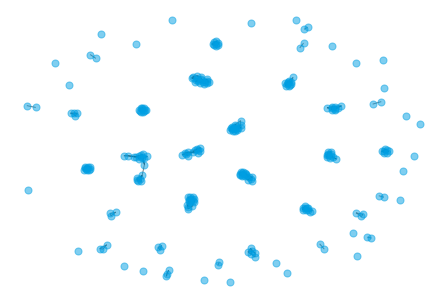

In [11]:
nx.draw(G, pos=nx.spring_layout(G), node_size = 50, node_color = "#009fe3",
        alpha = 0.5)

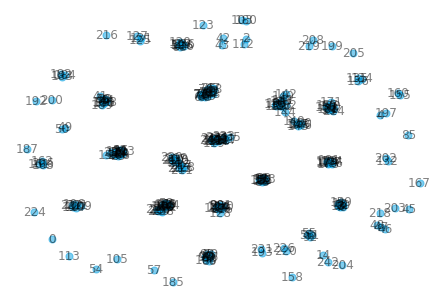

In [12]:
nx.draw(G, pos=nx.spring_layout(G), node_size = 50, node_color = "#009fe3",
        alpha = 0.5, with_labels = True)